# Initialization

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

plt.rcParams['figure.figsize'] = [16, 3]

import sys
sys.path.append('/mnt/lustre/IAM851/jm1667/psc/python')
import psc

import logging
# logging.basicConfig(level=logging.DEBUG)

%config InlineBackend.figure_format = 'retina'
engine = "pscadios2"

In [90]:
bstr = "med"
path = f"/mnt/lustre/IAM851/jm1667/psc-runs/trial_{bstr}B_n512_long_osc/"
length = {'med':(1., .03, .03), 'big':(1., .02, .02), 'small':(1., .18, .18)}[bstr]

## Plotting Demo 1

In [34]:
ds = xr.open_dataset(path + "pfd.000001000.bp", length=length, engine=engine)
print(ds._variables.keys())

dict_keys(['x', 'y', 'z', 'jx_ec', 'jy_ec', 'jz_ec', 'ex_ec', 'ey_ec', 'ez_ec', 'hx_fc', 'hy_fc', 'hz_fc'])


In [81]:
%matplotlib inline
# ds.jz_ec.sel(z=slice(0, 12)).coarsen(y=2, z=2).mean().plot()
# ds.hz_fc.coarsen(y=2, z=2).mean().plot()
ds.jy_ec.coarsen(y=2, z=2).mean().plot()
plt.gca().set_aspect('equal')

ValueError: Dimensions ['y', 'z'] not found in DataArray.

## Plotting Demo 2

In [83]:
moments = xr.open_dataset(path + "pfd_moments.000100000.bp", length=length, engine=engine)
print("t = ", moments._attrs['time'])

t =  3.107402847011195


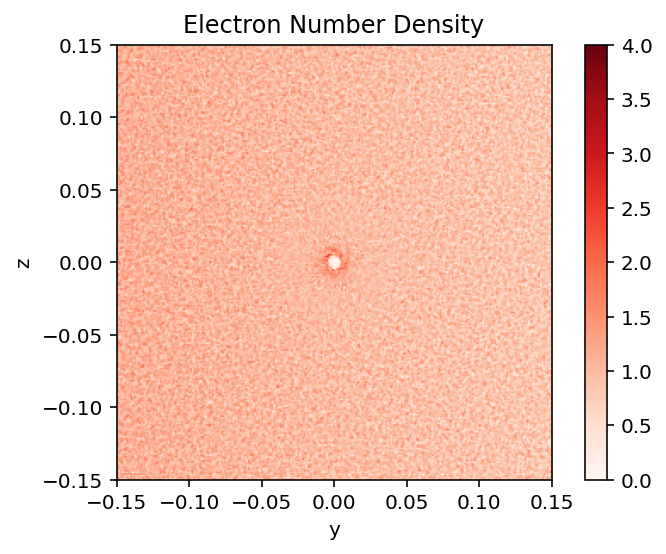

In [89]:
%matplotlib inline
fig, ax = plt.subplots()
data = (-moments.rho_e +moments.y).coarsen(y=2, z=2).mean()[0,:,:].transpose()[:,::-1] # data is initially z>, yv; we want y>, z^
im = ax.imshow(data, cmap='Reds', vmin=0, vmax=4, extent=(-length[1]/2, length[1]/2, -length[2]/2, length[2]/2))
ax.set_xlabel('y')
ax.set_ylabel('z')
fig.colorbar(im, ax=ax)
plt.title("Electron Number Density")
plt.show()

# Animation
from https://stackoverflow.com/questions/18743673/show-consecutive-images-arrays-with-imshow-as-repeating-animation-in-python
and http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

In [3]:
import matplotlib.animation as animation
from IPython.display import HTML

In [40]:
class ParamMetadata:
    def __init__(self, title, vmin, vmax, colors, fileName, varName, coef=1, skipFirst=False):
        self.title = title
        self.vmin = vmin
        self.vmax = vmax
        self.colors = colors
        self.fileName = fileName
        self.varName = varName
        self.coef = coef
        self.skipFirst = skipFirst

In [75]:
paramId = -1
hx0 = {'small':.1, 'med':1, 'big':10}[bstr]
param = [
        ParamMetadata('Electron Density', 0, 4, 'Reds', 'pfd_moments', 'rho_e', coef=-1),
        ParamMetadata('Y-ial E', -.0005, .0005, 'RdBu', 'pfd', 'ey_ec'),
        ParamMetadata('Y-ial B', -3e-8, 3e-8, 'RdBu', 'pfd', 'hy_fc', skipFirst=True),
        ParamMetadata('X-ial B', -hx0*1.2, hx0*1.2, 'RdBu', 'pfd', 'hx_fc'),
        ParamMetadata('Y-ial J', -.0005, .0005, 'RdBu', 'pfd', 'jy_ec', skipFirst=True),
#         ParamMetadata('Radial J', -.0005, .0005, 'RdBu', 'pfd', ['jy_ec', 'jz_ec'], skipFirst=True),
        ][paramId]

In [68]:
nframes = 100

# determine number of steps in file (will fail if run ran out of time)
with open(path + "psc_bgk_params_record.txt") as records:
    for line in records:
        if line.startswith("nmax"):
            nsteps = int(line.split()[1])

stepsPerFrame = nsteps // nframes

print(f"nsteps in sim: {nsteps}")
print(f"nframes in animation = {nframes}")
print(f"steps per frame: {stepsPerFrame}")

nsteps in sim: 1000000
nframes in animation = 100
steps per frame: 10000


In [76]:
%matplotlib ipympl
fig, ax = plt.subplots()

def openFile(fileName, step):
    return xr.open_dataset(path + f"{fileName}.{str(step).rjust(9,'0')}.bp", length=length, engine=engine)

def prepData(data):
    # data is initially z>, yv; we want y>, z^
    return data.coarsen(y=2, z=2).mean()[0,:,:].transpose()[:,::-1]

def getDataAndTime(frameIdx):
    if frameIdx == 0 and param.skipFirst:
        frameIdx = 1
    file = openFile(param.fileName, frameIdx*stepsPerFrame)
    if isinstance(param.varName, list):
        return param.coef * sum(prepData(file.__getattr__(var)) ** 2 for var in param.varName) ** .5, file._attrs['time']
    return param.coef * prepData(file.__getattr__(param.varName)), file._attrs['time']

def setTitle(ax, time):
    ax.set_title(param.title + " (t={:.2f})".format(time))

im = ax.imshow(getDataAndTime(0)[0], cmap=param.colors, vmin=param.vmin, vmax=param.vmax, extent=(-length[1]/2, length[1]/2, -length[2]/2, length[2]/2))
ax.set_xlabel('y')
ax.set_ylabel('z')
setTitle(ax, 0)
fig.colorbar(im, ax=ax)

def updateIm(frameIdx):
    data, time = getDataAndTime(frameIdx)
    im.set_array(data)
    setTitle(ax, time)
    return [im]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [77]:
%matplotlib ipympl
anim = animation.FuncAnimation(fig, updateIm, interval=30, frames=nframes, repeat=False, blit=True)
HTML(anim.to_html5_video())

## Stability Plot

In [78]:
import numpy as np

In [79]:
datas, times = [list(x) for x in zip(*[getDataAndTime(idx) for idx in range(nframes)])]
if param.skipFirst:
    del datas[0]
    del times[0]

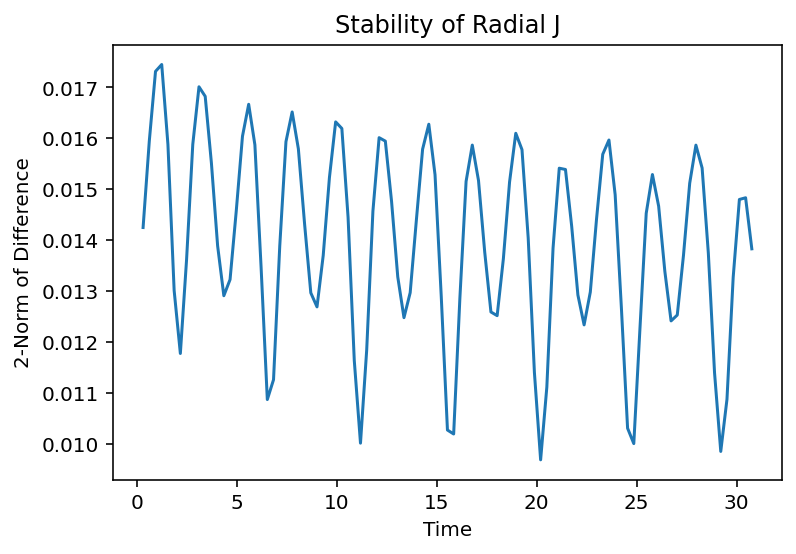

In [80]:
%matplotlib inline
def norm(x):
    return xr.apply_ufunc(np.linalg.norm, x, input_core_dims=[['y', 'z']])

normsOfDiffs = [norm(data - data[0]) for data in datas]

plt.xlabel("Time")
plt.ylabel("2-Norm of Difference")
plt.title("Stability of " + param.title)

plt.plot(times, normsOfDiffs)
plt.show()